In [3]:
import numpy as np
import os
from os.path import isfile
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, GRU
from tensorflow.keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda


from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend as K

from tensorflow.keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

### Load training and Validation arrays

In [4]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }


reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [5]:
npzfile = np.load('shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394,)


In [6]:
npzfile = np.load('shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


### Check by plotting a Spectogram

Electronic


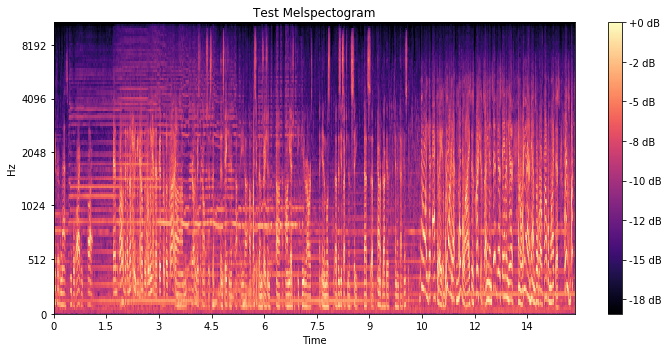

In [7]:
num = 5300
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

### Parallel CNN - RNN Model

In [8]:
batch_size = 32
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [9]:
nb_filters1=16 
nb_filters2=32 
nb_filters3=64
nb_filters4=64
nb_filters5=64
ksize = (3,1)
pool_size_1= (2,2) 
pool_size_2= (4,4)
pool_size_3 = (4,2)

dropout_prob = 0.20
dense_size1 = 128
lstm_count = 64
num_units = 120

BATCH_SIZE = 64
EPOCH_COUNT = 30
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_2)(conv_4)
    
    
    conv_5 = Conv2D(filters = nb_filters5, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_5')(pool_4)
    pool_5 = MaxPooling2D(pool_size_2)(conv_5)

    flatten1 = Flatten()(pool_5)
    ### Recurrent Block
    
    # Pooling layer
    pool_lstm1 = MaxPooling2D(pool_size_3, name = 'pool_lstm')(layer)
    
    # Embedding layer

    squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)
#     flatten2 = K.squeeze(pool_lstm1, axis = -1)
#     dense1 = Dense(dense_size1)(flatten)
    
    # Bidirectional GRU
    lstm = Bidirectional(GRU(lstm_count))(squeezed)  #default merge mode is concat
    
    # Concat Output
    concat = concatenate([flatten1, lstm], axis=-1, name ='concat')
    
    ## Softmax Output
    output = Dense(num_classes, activation = 'softmax', name='preds')(concat)
    
    model_output = output
    model = Model(model_input, model_output)
    
    model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer="RMSprop",
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [10]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_frequency = 128
    n_frames = 640
    #reshape and expand dims for conv2d
#     x_train = x_train.reshape(-1, n_frequency, n_frames)
    x_train = np.expand_dims(x_train, axis = -1)
    
#     x_val = x_val.reshape(-1, n_frequency, n_frames)
    x_val = np.expand_dims(x_val, axis = -1)
    
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/parallel/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history


In [14]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [12]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)

Building model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 640, 128, 1) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 638, 128, 16) 64          input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 319, 64, 16)  0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 317, 64, 32)  1568        max_pooling2d[0][0]              
____________________________________________________________________________

Epoch 10/30
6394/6394 [==============================] - 124s 19ms/sample - loss: 1.4429 - accuracy: 0.4891 - val_loss: 1.4663 - val_accuracy: 0.4613
Epoch 11/30
6394/6394 [==============================] - 125s 19ms/sample - loss: 1.4120 - accuracy: 0.5058 - val_loss: 1.6516 - val_accuracy: 0.4175
Epoch 12/30
6394/6394 [==============================] - 122s 19ms/sample - loss: 1.3889 - accuracy: 0.5056 - val_loss: 1.5392 - val_accuracy: 0.4538
Epoch 13/30
6394/6394 [==============================] - 122s 19ms/sample - loss: 1.3710 - accuracy: 0.5202 - val_loss: 1.6462 - val_accuracy: 0.3950
Epoch 14/30
6394/6394 [==============================] - 127s 20ms/sample - loss: 1.3426 - accuracy: 0.5302 - val_loss: 1.4697 - val_accuracy: 0.4675
Epoch 15/30
6394/6394 [==============================] - 128s 20ms/sample - loss: 1.3312 - accuracy: 0.5308 - val_loss: 1.5617 - val_accuracy: 0.4412
Epoch 16/30
6394/6394 [==============================] - 137s 21ms/sample - loss: 1.2944 - accuracy:

6394/6394 [==============================] - 161s 25ms/sample - loss: 0.9917 - accuracy: 0.6575 - val_loss: 1.5106 - val_accuracy: 0.5075
Epoch 28/30
6394/6394 [==============================] - 163s 25ms/sample - loss: 0.9575 - accuracy: 0.6644 - val_loss: 1.6589 - val_accuracy: 0.4875
Epoch 29/30
6394/6394 [==============================] - 189s 30ms/sample - loss: 0.9323 - accuracy: 0.6730 - val_loss: 1.6238 - val_accuracy: 0.4563
Epoch 30/30
6394/6394 [==============================] - 180s 28ms/sample - loss: 0.8758 - accuracy: 0.6925 - val_loss: 1.7660 - val_accuracy: 0.4850


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


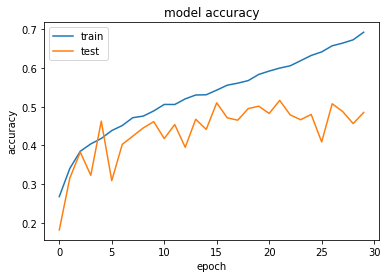

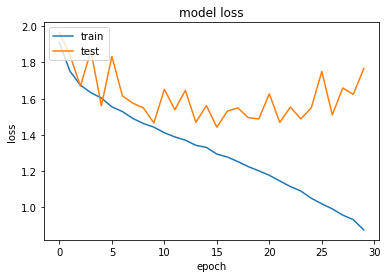

In [15]:
show_summary_stats(history)

In [17]:
from sklearn.metrics import classification_report

y_true = np.asarray(y_valid)
X_valid = np.expand_dims(X_valid, axis = -1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))


(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.42      0.55      0.48       100
 Experimental       0.35      0.56      0.43       100
         Folk       0.85      0.34      0.49       100
      Hip-Hop       0.48      0.73      0.58       100
 Instrumental       0.46      0.53      0.50       100
International       0.53      0.63      0.58       100
          Pop       0.00      0.00      0.00       100
         Rock       0.69      0.54      0.61       100

     accuracy                           0.48       800
    macro avg       0.47      0.49      0.46       800
 weighted avg       0.47      0.48      0.46       800



In [18]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.485


### Look at the Test Set

In [31]:
npzfile = np.load('test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']


MemoryError: Unable to allocate 500. MiB for an array with shape (65536000,) and data type float64

In [32]:
from tensorflow.keras.models import load_model

weights_path = 'models/parallel/weights.best.h5'
model = load_model(weights_path)

In [33]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

-1 6 2.5


In [34]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

MemoryError: Unable to allocate 500. MiB for an array with shape (800, 640, 128) and data type float64

In [28]:
X_test = np.log(X_test_raw)


from sklearn.metrics import classification_report

y_true = y_test
X_test = np.expand_dims(X_test, axis = -1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

NameError: name 'X_test_raw' is not defined

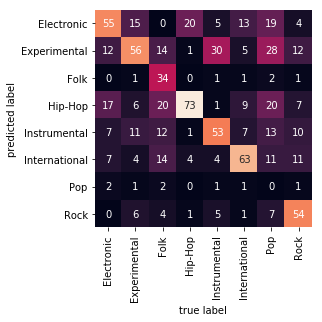

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

In [30]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, y_pred))

0.485
